In [2]:
!pip install q tensorflow==2.1

     |████████████████████████████████| 421.8MB 26kB/s 
     |████████████████████████████████| 450kB 43.4MB/s 
     |████████████████████████████████| 3.9MB 42.7MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=28b7f547b57baa3a36b05f015be019eca182b3aceedf19f95171496e209b95cb
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: 

In [ ]:
!pip install keras==2.3.1

# Segmentation of Indian Traffic

In [3]:
import math
from PIL import Image, ImageDraw
from PIL import ImagePath
import pandas as pd
import os
from os import path
from tqdm import tqdm
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Multiply
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, UpSampling2D, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

In [ ]:
label_clr = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\
                        'out of roi':0, 'ego vehicle':170, 'ground':180,'rectification border':190,\
                   'train':200}

### Training Unet

In [6]:
import tensorflow as tf
import os
import cv2
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Input,Conv2D,MaxPool2D,Activation,Dropout,Flatten, BatchNormalization, ReLU, Reshape
from tensorflow.keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau

import random as rn

Using TensorFlow backend.


In [7]:
%cd /content/drive/MyDrive/segmentation

/content/drive/MyDrive/segmentation


In [8]:
data_df=pd.read_csv('preprocessed_data.csv')

In [9]:
from sklearn.model_selection import train_test_split
x_tr, x_cv, y_tr, y_cv = train_test_split(data_df['image'], data_df['mask'], random_state=33, test_size=0.2)

In [10]:
!pip install -U segmentation-models==0.2.1

     |████████████████████████████████| 51kB 6.6MB/s 
     |████████████████████████████████| 81kB 9.1MB/s 


In [11]:
from segmentation_models import Unet
from segmentation_models.utils import set_trainable
import segmentation_models as sm
tf.keras.backend.set_image_data_format('channels_last')

/usr/local/lib/python3.7/dist-packages/classification_models/resnext/__init__.py:4: UserWarning: Current ResNext models are deprecated, use keras.applications ResNeXt models
  warnings.warn('Current ResNext models are deprecated, '


In [12]:
model = Unet('resnet34', encoder_weights='imagenet', classes=21, activation='sigmoid', encoder_freeze= True, input_shape=(256,256,3))

85524480/85521592 [==============================] - 2s 0us/step


In [6]:
model.summary()

Model: "u-resnet34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 256, 256, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 262, 262, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 128, 128, 64) 9408        zero_padding2d_1[0][0]           
_________________________________________________________________________________________

In [13]:
aug2 = iaa.Fliplr(1)
aug3 = iaa.Flipud(1)
aug4 = iaa.Emboss(alpha=(1), strength=1)
aug5 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))

In [14]:
def normalize_image(mask):
    mask = mask/255
    return mask

def getImageArr(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED) 
    img = np.float32(cv2.resize(img,(256,256),interpolation=cv2.INTER_AREA))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img=normalize_image(img)
    return img
    
def getSegmentationArr(path, nClasses=21): 
    seg_labels = np.zeros((256,256, nClasses))
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED) 
    img = np.float32(cv2.resize(img,(256,256),interpolation=cv2.INTER_AREA))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img[:, : , 0]

    for i,c in enumerate(set(label_clr.values())):
        seg_labels[:, :, i] = (img == c).astype(int)
    return seg_labels

In [17]:
def image_generator(image_paths,mask_paths, batch_size=4,training=True):
    while True:
        num_samples = len(image_paths)
        for offset in range(0, num_samples, batch_size):
            image_path = image_paths[offset:offset+batch_size]
            mask_path = mask_paths[offset:offset+batch_size]
            batch_input = []
            batch_output = [] 
            # Read in each input, perform preprocessing and get labels
            for input_path,seg_path in zip(image_path,mask_path):
                image = getImageArr(input_path)
                seg_mask = getSegmentationArr(seg_path,nClasses=21)
                if training:
                    batch_input.append(image)
                    batch_output.append(seg_mask) 
                    image1 = aug2.augment_image(image)
                    seg_mask1 = aug2.augment_image(seg_mask)

                    batch_input.append(image1)
                    batch_output.append(seg_mask1)
                    image2 = aug3.augment_image(image)
                    seg_mask2 = aug3.augment_image(seg_mask)

                    batch_input.append(image2)
                    batch_output.append(seg_mask2)
                    image3 = aug4.augment_image(image)
                    seg_mask3 = aug4.augment_image(seg_mask)

                    batch_input.append(image3)
                    batch_output.append(seg_mask3)
                    image4 = aug5.augment_image(image)
                    seg_mask4 = aug5.augment_image(seg_mask)
                    
                    batch_input.append(image4)
                    batch_output.append(seg_mask4)
                else:
                    batch_input.append(image)
                    batch_output.append(seg_mask)
                    # Return a tuple of (input, output) to feed the network
            batch_x = np.array( batch_input)
            batch_y = np.array( batch_output)
            yield ( batch_x, batch_y )

In [18]:
train_gen = image_generator(x_tr, y_tr, batch_size = 8, training=True)
val_gen = image_generator(x_cv, y_cv, batch_size=8, training=False)

In [17]:
import segmentation_models as sm
from segmentation_models.metrics import iou_score
from segmentation_models import Unet

optim = tf.keras.optimizers.Adam(lr=0.0001)
focal_loss = sm.losses.cce_dice_loss

model.compile(optim, focal_loss, metrics=[iou_score])

In [18]:
%cd /content/drive/MyDrive/segmentation

/content/drive/MyDrive/segmentation


In [ ]:
checkpoint = ModelCheckpoint('weight',monitor="val_iou_score", mode="max",save_best_only = True,verbose=1)

### Compile

In [ ]:
history = model.fit_generator(train_gen,steps_per_epoch = (np.ceil(len(x_tr)/20)),
                              validation_data=val_gen, validation_steps=(np.ceil(len(x_cv)/20)),
                              epochs = 5,verbose = 1,workers=-1,use_multiprocessing=True, callbacks=[checkpoint])

Epoch 1/5
81/81 [==============================] - 873s 11s/step - loss: 2.3507 - iou_score: 0.1693 - val_loss: 3.4002 - val_iou_score: 0.2835

Epoch 00001: val_iou_score improved from -inf to 0.28354, saving model to weight


/usr/local/lib/python3.7/dist-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


Epoch 2/5
81/81 [==============================] - 823s 10s/step - loss: 1.9751 - iou_score: 0.3489 - val_loss: 6.3698 - val_iou_score: 0.2752

Epoch 00002: val_iou_score did not improve from 0.28354
Epoch 3/5
81/81 [==============================] - 449s 6s/step - loss: 2.0813 - iou_score: 0.2939 - val_loss: 8.7470 - val_iou_score: 0.2679

Epoch 00003: val_iou_score did not improve from 0.28354
Epoch 4/5
81/81 [==============================] - 156s 2s/step - loss: 1.7037 - iou_score: 0.3119 - val_loss: 6.5416 - val_iou_score: 0.2570

Epoch 00004: val_iou_score did not improve from 0.28354
Epoch 5/5
81/81 [==============================] - 155s 2s/step - loss: 1.5860 - iou_score: 0.3569 - val_loss: 8.5051 - val_iou_score: 0.2580

Epoch 00005: val_iou_score did not improve from 0.28354


In [ ]:
history = model.fit_generator(train_gen,steps_per_epoch = (np.ceil(len(x_tr)/20)),
                              validation_data=val_gen, validation_steps=(np.ceil(len(x_cv)/20)),
                              epochs = 5,verbose = 1,workers=-1,use_multiprocessing=True,callbacks=[checkpoint])

Epoch 1/5
81/81 [==============================] - 164s 2s/step - loss: 1.3033 - iou_score: 0.3355 - val_loss: 2.7980 - val_iou_score: 0.2747

Epoch 00001: val_iou_score did not improve from 0.28354
Epoch 2/5
81/81 [==============================] - 155s 2s/step - loss: -inf - iou_score: inf - val_loss: 2.0995 - val_iou_score: 0.2998

Epoch 00002: val_iou_score improved from 0.28354 to 0.29976, saving model to weight


/usr/local/lib/python3.7/dist-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


Epoch 3/5
81/81 [==============================] - 154s 2s/step - loss: 1.3022 - iou_score: 0.3353 - val_loss: 1.8370 - val_iou_score: 0.3326

Epoch 00003: val_iou_score improved from 0.29976 to 0.33262, saving model to weight
Epoch 4/5
81/81 [==============================] - 156s 2s/step - loss: 1.2951 - iou_score: 0.3380 - val_loss: 1.2879 - val_iou_score: 0.3448

Epoch 00004: val_iou_score improved from 0.33262 to 0.34481, saving model to weight
Epoch 5/5
81/81 [==============================] - 154s 2s/step - loss: -inf - iou_score: inf - val_loss: 1.6203 - val_iou_score: 0.3486

Epoch 00005: val_iou_score improved from 0.34481 to 0.34857, saving model to weight


In [ ]:
history = model.fit_generator(train_gen,steps_per_epoch = (np.ceil(len(x_tr)/20)),
                              validation_data=val_gen, validation_steps=(np.ceil(len(x_cv)/20)),
                              epochs = 5,verbose = 1,workers=-1,use_multiprocessing=True,callbacks=[checkpoint])

Epoch 1/5
81/81 [==============================] - 165s 2s/step - loss: 1.2809 - iou_score: 0.3373 - val_loss: 1.5252 - val_iou_score: 0.3529

Epoch 00001: val_iou_score improved from 0.34857 to 0.35292, saving model to weight


/usr/local/lib/python3.7/dist-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


Epoch 2/5
81/81 [==============================] - 155s 2s/step - loss: -inf - iou_score: inf - val_loss: 1.1028 - val_iou_score: 0.3558

Epoch 00002: val_iou_score improved from 0.35292 to 0.35579, saving model to weight
Epoch 3/5
81/81 [==============================] - 155s 2s/step - loss: 1.3027 - iou_score: 0.3355 - val_loss: 1.2041 - val_iou_score: 0.3555

Epoch 00003: val_iou_score did not improve from 0.35579
Epoch 4/5
81/81 [==============================] - 156s 2s/step - loss: 1.2905 - iou_score: 0.3381 - val_loss: 1.5502 - val_iou_score: 0.3530

Epoch 00004: val_iou_score did not improve from 0.35579
Epoch 5/5
81/81 [==============================] - 153s 2s/step - loss: -inf - iou_score: inf - val_loss: 1.2560 - val_iou_score: 0.3564

Epoch 00005: val_iou_score improved from 0.35579 to 0.35642, saving model to weight


In [ ]:
history = model.fit_generator(train_gen,steps_per_epoch = (np.ceil(len(x_tr)/20)),
                              validation_data=val_gen, validation_steps=(np.ceil(len(x_cv)/20)),
                              epochs = 10,verbose = 1,workers=-1,use_multiprocessing=True,callbacks=[checkpoint])

Epoch 1/10
81/81 [==============================] - 164s 2s/step - loss: 1.2768 - iou_score: 0.3376 - val_loss: 1.6848 - val_iou_score: 0.3525

Epoch 00001: val_iou_score did not improve from 0.35642
Epoch 2/10
81/81 [==============================] - 154s 2s/step - loss: -inf - iou_score: inf - val_loss: 1.4568 - val_iou_score: 0.3560

Epoch 00002: val_iou_score did not improve from 0.35642
Epoch 3/10
81/81 [==============================] - 155s 2s/step - loss: 1.3019 - iou_score: 0.3356 - val_loss: 1.3404 - val_iou_score: 0.3562

Epoch 00003: val_iou_score did not improve from 0.35642
Epoch 4/10
81/81 [==============================] - 156s 2s/step - loss: 1.2940 - iou_score: 0.3380 - val_loss: 1.6681 - val_iou_score: 0.3537

Epoch 00004: val_iou_score did not improve from 0.35642
Epoch 5/10
81/81 [==============================] - 155s 2s/step - loss: -inf - iou_score: inf - val_loss: 1.5385 - val_iou_score: 0.3573

Epoch 00005: val_iou_score improved from 0.35642 to 0.35727, savin

/usr/local/lib/python3.7/dist-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


Epoch 6/10
81/81 [==============================] - 155s 2s/step - loss: 1.2731 - iou_score: 0.3377 - val_loss: 1.3551 - val_iou_score: 0.3521

Epoch 00006: val_iou_score did not improve from 0.35727
Epoch 7/10
81/81 [==============================] - 154s 2s/step - loss: -inf - iou_score: inf - val_loss: 1.3351 - val_iou_score: 0.3565

Epoch 00007: val_iou_score did not improve from 0.35727
Epoch 8/10
81/81 [==============================] - 153s 2s/step - loss: 1.3007 - iou_score: 0.3356 - val_loss: 1.4555 - val_iou_score: 0.3546

Epoch 00008: val_iou_score did not improve from 0.35727
Epoch 9/10
81/81 [==============================] - 155s 2s/step - loss: 1.2927 - iou_score: 0.3381 - val_loss: 1.5551 - val_iou_score: 0.3549

Epoch 00009: val_iou_score did not improve from 0.35727
Epoch 10/10
81/81 [==============================] - 153s 2s/step - loss: -inf - iou_score: inf - val_loss: 1.6101 - val_iou_score: 0.3564

Epoch 00010: val_iou_score did not improve from 0.35727


In [16]:
model.load_weights('weight')

In [ ]:
history = model.fit_generator(train_gen,steps_per_epoch = (np.ceil(len(x_tr)/20)),
                              validation_data=val_gen, validation_steps=(np.ceil(len(x_cv)/20)),
                              epochs = 5,verbose = 1,workers=-1,use_multiprocessing=True,callbacks=[checkpoint])

Epoch 1/5
81/81 [==============================] - 174s 2s/step - loss: 1.0255 - iou_score: 0.3784 - val_loss: 0.9916 - val_iou_score: 0.3898

Epoch 00001: val_iou_score improved from 0.36449 to 0.38978, saving model to weight


/usr/local/lib/python3.7/dist-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


Epoch 2/5
81/81 [==============================] - 167s 2s/step - loss: 0.9561 - iou_score: 0.3865 - val_loss: 1.1838 - val_iou_score: 0.4070

Epoch 00002: val_iou_score improved from 0.38978 to 0.40700, saving model to weight
Epoch 3/5
81/81 [==============================] - 167s 2s/step - loss: 0.8700 - iou_score: 0.3953 - val_loss: 1.2935 - val_iou_score: 0.4102

Epoch 00003: val_iou_score improved from 0.40700 to 0.41019, saving model to weight
Epoch 4/5
81/81 [==============================] - 167s 2s/step - loss: 0.8584 - iou_score: 0.3999 - val_loss: 1.4587 - val_iou_score: 0.4174

Epoch 00004: val_iou_score improved from 0.41019 to 0.41741, saving model to weight
Epoch 5/5
81/81 [==============================] - 165s 2s/step - loss: 0.8355 - iou_score: 0.4046 - val_loss: 1.0881 - val_iou_score: 0.4270

Epoch 00005: val_iou_score improved from 0.41741 to 0.42697, saving model to weight


In [ ]:
history = model.fit_generator(train_gen,steps_per_epoch = (np.ceil(len(x_tr)/20)),
                              validation_data=val_gen, validation_steps=(np.ceil(len(x_cv)/20)),
                              epochs = 15,verbose = 1,workers=-1,use_multiprocessing=True,callbacks=[checkpoint])

Epoch 1/15
81/81 [==============================] - 167s 2s/step - loss: 0.7846 - iou_score: 0.4135 - val_loss: 1.1762 - val_iou_score: 0.4377

Epoch 00001: val_iou_score improved from 0.42697 to 0.43771, saving model to weight


/usr/local/lib/python3.7/dist-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


Epoch 2/15
81/81 [==============================] - 167s 2s/step - loss: 0.7984 - iou_score: 0.4131 - val_loss: 0.8362 - val_iou_score: 0.4175

Epoch 00002: val_iou_score did not improve from 0.43771
Epoch 3/15
81/81 [==============================] - 166s 2s/step - loss: 0.7392 - iou_score: 0.4221 - val_loss: 0.8791 - val_iou_score: 0.4374

Epoch 00003: val_iou_score did not improve from 0.43771
Epoch 4/15
81/81 [==============================] - 166s 2s/step - loss: 0.7500 - iou_score: 0.4220 - val_loss: 2.4672 - val_iou_score: 0.4145

Epoch 00004: val_iou_score did not improve from 0.43771
Epoch 5/15
81/81 [==============================] - 164s 2s/step - loss: 0.7275 - iou_score: 0.4256 - val_loss: 0.8612 - val_iou_score: 0.4463

Epoch 00005: val_iou_score improved from 0.43771 to 0.44632, saving model to weight
Epoch 6/15
81/81 [==============================] - 165s 2s/step - loss: 0.7003 - iou_score: 0.4322 - val_loss: 1.2650 - val_iou_score: 0.4299

Epoch 00006: val_iou_score d

In [ ]:
history = model.fit_generator(train_gen,steps_per_epoch = (np.ceil(len(x_tr)/20)),
                              validation_data=val_gen, validation_steps=(np.ceil(len(x_cv)/20)),
                              epochs = 5,verbose = 1,workers=-1,use_multiprocessing=True,callbacks=[checkpoint])

Epoch 1/5
81/81 [==============================] - 173s 2s/step - loss: 0.7041 - iou_score: 0.4130 - val_loss: 1.9460 - val_iou_score: 0.4130

Epoch 00001: val_iou_score did not improve from 0.45493
Epoch 2/5
81/81 [==============================] - 165s 2s/step - loss: 0.6677 - iou_score: 0.4450 - val_loss: 1.3133 - val_iou_score: 0.3992

Epoch 00002: val_iou_score did not improve from 0.45493
Epoch 3/5
81/81 [==============================] - 164s 2s/step - loss: 0.6481 - iou_score: 0.4440 - val_loss: 1.6567 - val_iou_score: 0.4378

Epoch 00003: val_iou_score did not improve from 0.45493
Epoch 4/5
81/81 [==============================] - 165s 2s/step - loss: 0.6221 - iou_score: 0.4481 - val_loss: 0.7980 - val_iou_score: 0.4489

Epoch 00004: val_iou_score did not improve from 0.45493
Epoch 5/5
81/81 [==============================] - 164s 2s/step - loss: 0.6115 - iou_score: 0.4640 - val_loss: 0.8048 - val_iou_score: 0.4633

Epoch 00005: val_iou_score improved from 0.45493 to 0.46335, 

/usr/local/lib/python3.7/dist-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


In [ ]:
history = model.fit_generator(train_gen,steps_per_epoch = (np.ceil(len(x_tr)/20)),
                              validation_data=val_gen, validation_steps=(np.ceil(len(x_cv)/20)),
                              epochs = 5,verbose = 1,workers=-1,use_multiprocessing=True,callbacks=[checkpoint])

Epoch 1/5
81/81 [==============================] - 166s 2s/step - loss: 0.5076 - iou_score: 0.4806 - val_loss: 0.7743 - val_iou_score: 0.4695

Epoch 00001: val_iou_score did not improve from 0.47796
Epoch 2/5
81/81 [==============================] - 166s 2s/step - loss: 0.4913 - iou_score: 0.5332 - val_loss: 0.7663 - val_iou_score: 0.4884

Epoch 00002: val_iou_score improved from 0.47796 to 0.48842, saving model to weight


/usr/local/lib/python3.7/dist-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


Epoch 3/5
81/81 [==============================] - 165s 2s/step - loss: 0.4873 - iou_score: 0.6610 - val_loss: 1.1776 - val_iou_score: 0.4757

Epoch 00003: val_iou_score did not improve from 0.48842
Epoch 4/5
81/81 [==============================] - 165s 2s/step - loss: 0.4740 - iou_score: 0.4975 - val_loss: 0.7964 - val_iou_score: 0.4775

Epoch 00004: val_iou_score did not improve from 0.48842
Epoch 5/5
81/81 [==============================] - 164s 2s/step - loss: 0.4746 - iou_score: 0.4915 - val_loss: 1.5237 - val_iou_score: 0.4565

Epoch 00005: val_iou_score did not improve from 0.48842


In [ ]:
history = model.fit_generator(train_gen,steps_per_epoch = (np.ceil(len(x_tr)/20)),
                              validation_data=val_gen, validation_steps=(np.ceil(len(x_cv)/20)),
                              epochs = 5,verbose = 1,workers=-1,use_multiprocessing=True,callbacks=[checkpoint])

Epoch 1/5
81/81 [==============================] - 165s 2s/step - loss: 0.4539 - iou_score: 0.5777 - val_loss: 0.7932 - val_iou_score: 0.4816

Epoch 00001: val_iou_score did not improve from 0.48842
Epoch 2/5
81/81 [==============================] - 164s 2s/step - loss: 0.4436 - iou_score: 0.5835 - val_loss: 0.7441 - val_iou_score: 0.4921

Epoch 00002: val_iou_score improved from 0.48842 to 0.49210, saving model to weight


/usr/local/lib/python3.7/dist-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


Epoch 3/5
81/81 [==============================] - 164s 2s/step - loss: 0.4466 - iou_score: 0.3044 - val_loss: 0.9735 - val_iou_score: 0.4732

Epoch 00003: val_iou_score did not improve from 0.49210
Epoch 4/5
81/81 [==============================] - 164s 2s/step - loss: 0.4296 - iou_score: 0.3897 - val_loss: 0.8042 - val_iou_score: 0.4858

Epoch 00004: val_iou_score did not improve from 0.49210
Epoch 5/5
81/81 [==============================] - 164s 2s/step - loss: 0.4211 - iou_score: 0.5119 - val_loss: 0.9254 - val_iou_score: 0.4820

Epoch 00005: val_iou_score did not improve from 0.49210


In [ ]:
history = model.fit_generator(train_gen,steps_per_epoch = (np.ceil(len(x_tr)/20)),
                              validation_data=val_gen, validation_steps=(np.ceil(len(x_cv)/20)),
                              epochs = 5,verbose = 1,workers=-1,use_multiprocessing=True,callbacks=[checkpoint])

Epoch 1/5
81/81 [==============================] - 166s 2s/step - loss: 0.3994 - iou_score: 0.5205 - val_loss: 0.7040 - val_iou_score: 0.4851

Epoch 00001: val_iou_score did not improve from 0.49843
Epoch 2/5
81/81 [==============================] - 165s 2s/step - loss: 0.3808 - iou_score: 0.5225 - val_loss: 0.7502 - val_iou_score: 0.5093

Epoch 00002: val_iou_score improved from 0.49843 to 0.50934, saving model to weight


/usr/local/lib/python3.7/dist-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


Epoch 3/5
81/81 [==============================] - 166s 2s/step - loss: 0.3833 - iou_score: 0.5604 - val_loss: 1.0171 - val_iou_score: 0.4640

Epoch 00003: val_iou_score did not improve from 0.50934
Epoch 4/5
81/81 [==============================] - 166s 2s/step - loss: 0.3754 - iou_score: 0.9179 - val_loss: 0.8657 - val_iou_score: 0.4925

Epoch 00004: val_iou_score did not improve from 0.50934
Epoch 5/5
81/81 [==============================] - 165s 2s/step - loss: 0.9613 - iou_score: 0.4223 - val_loss: 10.6949 - val_iou_score: 0.2699

Epoch 00005: val_iou_score did not improve from 0.50934


In [20]:
model.load_weights('weight')

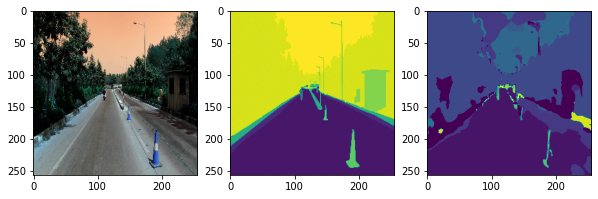

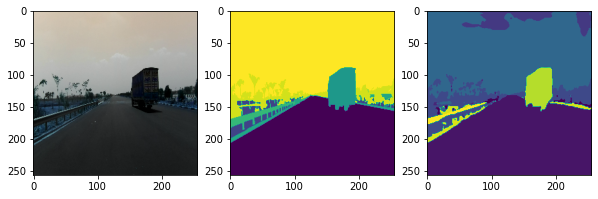

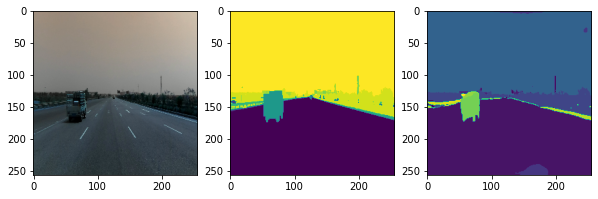

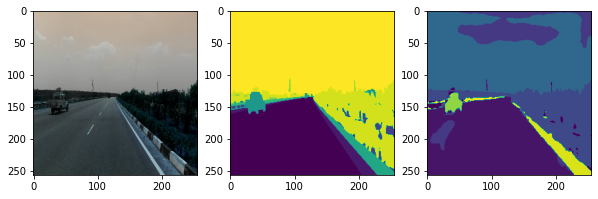

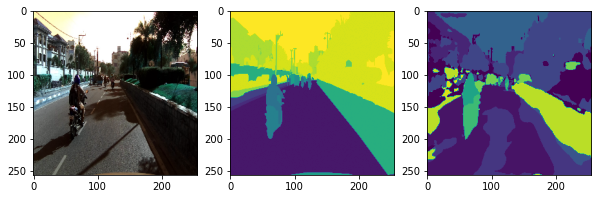

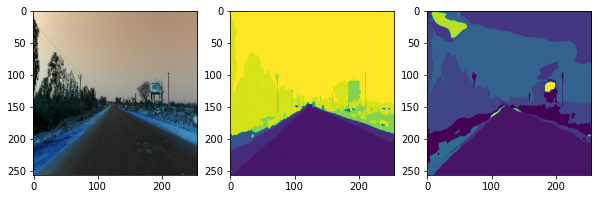

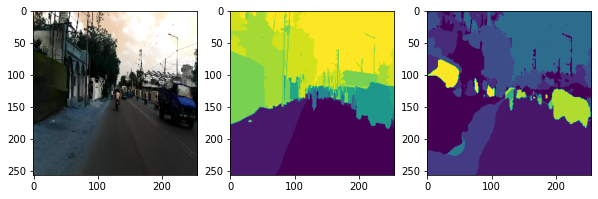

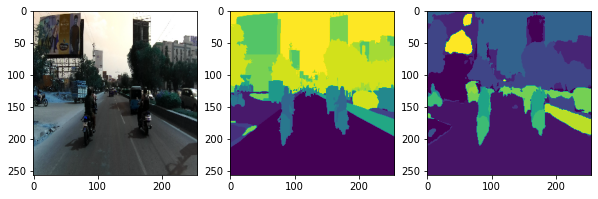

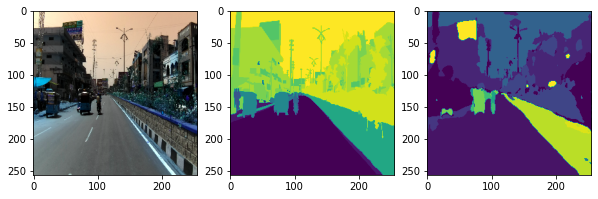

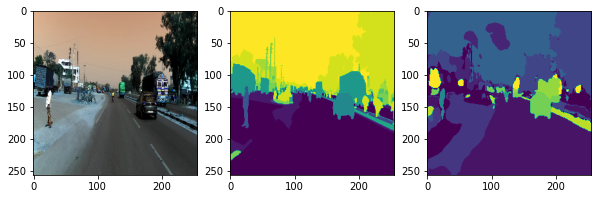

In [124]:
for i in range(0,10):
  image = cv2.imread('/content/drive/MyDrive/segmentation/'+x_cv.iloc[i], cv2.IMREAD_UNCHANGED)
  image = cv2.resize(image, (256,256))
  image=normalize_image(image)

  predicted  = model.predict(image[np.newaxis,:,:,:])
  prediction = tf.argmax(predicted, axis=-1)
  pred_mask = prediction[..., tf.newaxis]

#original segmentation map
  image_mask = cv2.imread('/content/drive/MyDrive/segmentation/'+y_cv.iloc[i], cv2.IMREAD_UNCHANGED)
  image_mask = cv2.resize(image_mask, (256,256))
  image_mask=normalize_image(image_mask)


  plt.figure(figsize=(10,6))
  plt.subplot(131)
  plt.imshow(image)
  plt.subplot(132)
  plt.imshow(image_mask)
  plt.subplot(133)
  plt.imshow(pred_mask[0,:,:,0])
  plt.show()